**Copyright 2020 Marcel Arpogaus**

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
 
        http://www.apache.org/licenses/LICENSE-2.0
 
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

**Note:** You might want to install the [`jupyter_latex_envs`](https://github.com/jfbercher/jupyter_latex_envs/) extension for Jupyter notebook to display the citations correctly.

# Implementation of Bernstein-Polynomials as TensorFlow Probability Bijector

Normalizing flows (NF) \cite{tabak-FamilyNonparametricDensity-2013} are a type of transformation model that can be used for density estimation.
Instead of parameterizing a density function to fit the shape of the desired conditional probability distribution, they use a single simple PDF, usually a Gaussian. As a *base distribution* and pass it through a series of special transformation functions until it is most similar to the *data distribution*.
This composition of simple transformation functions allows NF based models to be very expressive, while staying computational efficient \cite{papamakarios-NormalizingFlowsProbabilistic-2019}.

Conditioned normalizing flows can be used for complex conditional density estimation (CDE), without assuming much about their shape \cite{hothorn-MostLikelyTransformations-2018, sick-DeepTransformationModels-2020}.
Their expressiveness is highly dependent on the flexibility of the used transformation functions.
A recent study \cite{sick-DeepTransformationModels-2020} presented a new type of flow-based transformation models especially optimized for CDE.
They joined ideas from statistical transformation models \cite{hothorn-MostLikelyTransformations-2018} as well as deep normalizing flows \cite{tabak-FamilyNonparametricDensity-2013} and were able to outperform existing models for complex distributions far away from Gaussian.

Compared to the statistical transformation models the proposed deep transformation model does not require predefined features and can be trained in an end-to-end fashion from complex data.
The very expressive Bernstein polynomials are used as basis transformations \cite{hothorn-MostLikelyTransformations-2018} combined in a composition of four different transformation functions to build a NF.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies-&amp;-Prerequisites" data-toc-modified-id="Dependencies-&amp;-Prerequisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies &amp; Prerequisites</a></span><ul class="toc-item"><li><span><a href="#Import-Libaries" data-toc-modified-id="Import-Libaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libaries</a></span></li><li><span><a href="#Ensure-Reproducibility" data-toc-modified-id="Ensure-Reproducibility-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ensure Reproducibility</a></span></li><li><span><a href="#File-Paths" data-toc-modified-id="File-Paths-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File Paths</a></span></li></ul></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#TensorFlow-Dataset-API" data-toc-modified-id="TensorFlow-Dataset-API-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TensorFlow Dataset API</a></span></li></ul></li><li><span><a href="#Bernstein-Bijector-as-Distribution-Lambda" data-toc-modified-id="Bernstein-Bijector-as-Distribution-Lambda-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bernstein Bijector as Distribution Lambda</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Berstein-Bijector-as-Loss" data-toc-modified-id="Berstein-Bijector-as-Loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Berstein Bijector as Loss</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li></ul></div>

##  Dependencies & Prerequisites

### Import Libaries

In [1]:
import os
import pandas as pd
import numpy as np

from functools import partial

import scipy.interpolate as I

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
sns.set(style="ticks", context="paper")  # improved plt styles

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

from tensorflow.keras import Sequential, Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Dense, Input, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util

In [3]:
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util

### Ensure Reproducibility

In [4]:
np.random.seed(2)
tf.random.set_seed(2)
print("TFP Version", tfp.__version__)
print("TF  Version", tf.__version__)

TFP Version 0.11.0
TF  Version 2.3.0


### File Paths

In [5]:
gfx_path = './gfx'

## Function Definitions

We want to directly minimize the negative log-likelihood:

In [6]:
def negloglik(y_true, y_hat):
    nll = -y_hat.log_prob(y_true)
    return nll

In [7]:
def vizualize_flow_from_z_domain(flow):
    bijector = flow.bijector
    base_dist = flow.distribution

    n = 1000

    # z ~ p_z
    z_samples = np.linspace(-3, 3, n, dtype=np.float32)  # flow.sample(n)
    z_probs = base_dist.prob(z_samples)

    # y = h(z)
    y_samples = np.squeeze(bijector.forward(z_samples))

    # p_y(y) = p_z(h^-1(y))*|h^-1'(y)| = p_z(z)*|h^-1'(y)|
    ildj = bijector.inverse_log_det_jacobian(y_samples[..., None], 1)
    log_prob = base_dist.log_prob(z_samples)
    log_prob = log_prob + ildj

    y_probs = np.exp(log_prob)

    fig = plt.figure(figsize=(8, 8))

    gs1 = gridspec.GridSpec(2, 2)

    b_ax = fig.add_subplot(gs1[0, 1])
    b_ax.spines['top'].set_color('none')  # don't draw spine
    b_ax.spines['right'].set_color('none')  # don't draw spine
    b_ax.spines['bottom'].set_position(('outward', 10))
    b_ax.spines['left'].set_position(('outward', 10))

    b_ax.set_xlabel('z')
    b_ax.set_ylabel('y')

    y_ax = fig.add_subplot(gs1[0, 0], sharey=b_ax)
    y_ax.axis('off')
    plt.gca().invert_xaxis()

    z_ax = fig.add_subplot(gs1[1, 1], sharex=b_ax)
    z_ax.axis('off')
    plt.gca().invert_yaxis()

    gs1.tight_layout(fig)

    z_ax.plot(z_samples, z_probs)
    b_ax.plot(z_samples, y_samples)
    y_ax.plot(y_probs, y_samples)

    mu_z = base_dist.mean()

    mu_y = bijector.forward(mu_z)

    p_mu_z = base_dist.prob(mu_z)
    p_mu_y = np.exp(base_dist.log_prob(mu_z) +
                    bijector.inverse_log_det_jacobian(mu_y, 1))

    cp_kwds = dict(
        color='darkgray',
        lw=1,
        ls='--',
        arrowstyle='->'
    )

    project_y = ConnectionPatch(
        xyA=(mu_z, p_mu_z),
        xyB=(mu_z, mu_y),
        coordsA='data',
        coordsB='data',
        axesA=z_ax,
        axesB=b_ax,
        **cp_kwds
    )
    z_ax.add_artist(project_y)

    project_y = ConnectionPatch(
        xyA=(mu_z, mu_y),
        xyB=(p_mu_y, mu_y),
        coordsA='data',
        coordsB='data',
        axesA=b_ax,
        axesB=y_ax,
        **cp_kwds
    )
    b_ax.add_artist(project_y)

    return fig

In [8]:
def plot_chained_bijectors(flow):
    chained_bijectors = flow.bijector.bijector.bijectors
    base_dist = flow.distribution
    cols = len(chained_bijectors) + 1
    fig, ax = plt.subplots(1, cols, figsize=(4*cols, 4))

    n = 200

    z_samples = np.linspace(-3, 3, n).astype(np.float32)
    log_probs = base_dist.log_prob(z_samples)

    ax[0].plot(z_samples, np.exp(log_probs))

    zz = z_samples[..., None]
    ildj = 0.
    for i, (a, b) in enumerate(zip(ax[1:], chained_bijectors)):
        # we need to use the inverse here since we are going from z->y!
        z = b.inverse(zz)
        ildj += b.forward_log_det_jacobian(z, 1)
        #print(z.shape, zz.shape, ildj.shape)
        a.plot(z, np.exp(log_probs + ildj))
        a.set_title(b.name.replace('_', ' '))
        a.set_xlabel(f'$z_{i}$')
        a.set_ylabel(f'$p(z_{i+1})$')
        zz = z
    fig.tight_layout()

In [9]:
def plot_flow(flow, y, ax=plt, color='skyblue'):
    base_dist = flow.distribution
    bijector = flow.bijector

    dense_y = flow.prob(y).numpy()

    mu = np.squeeze(bijector.forward(base_dist.mean()))
    plus_sd = np.squeeze(bijector.forward(
        base_dist.mean() + base_dist.stddev()))
    minus_sd = np.squeeze(bijector.forward(
        base_dist.mean() - base_dist.stddev()))

    ax.plot(
        [mu, mu],
        [np.min(dense_y),
         flow.prob(mu.reshape(-1, 1)).numpy()],
        color='black',
        lw=2
    )
    ax.plot(
        [plus_sd, plus_sd],
        [np.min(dense_y), flow.prob(plus_sd.reshape(-1, 1)).numpy()],
        '--',
        color='green'
    )
    ax.plot(
        [minus_sd, minus_sd],
        [np.min(dense_y), flow.prob(minus_sd.reshape(-1, 1)).numpy()],
        '--',
        color='green'
    )

    def quant(p):
        q = bijector.forward(base_dist.quantile(p))
        return np.squeeze(q)

    qs = [.05, .1, .2, .3, .4]
    ax.fill_between(
        np.squeeze(y),
        np.squeeze(dense_y),
        np.min(dense_y),
        fc=color,
        alpha=max(qs)
    )
    for i, q in enumerate(sorted(qs)):
        ax.fill_between(
            np.squeeze(y),
            np.squeeze(dense_y),
            np.min(dense_y),
            where=(
                (np.squeeze(y) > quant(q)) & (np.squeeze(y) < quant(1-q))
            ),
            fc=color,
            alpha=q / max(qs)
        )

    ax.plot(
        y,
        dense_y,
        '-',
        color=color,
        linewidth=2
    )

Implementing the Bernstein polynomial using the [`tf.Bijector`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) interface for transformations of a `Distribution` sample.

In [10]:
class BernsteinBijector(tfb.Bijector):

    def __init__(self,
                 len_theta,
                 theta,
                 validate_args=False,
                 name='bernstein_bijector'):
        with tf.name_scope(name) as name:
            dtype = dtype_util.common_dtype([theta], dtype_hint=tf.float32)

            super().__init__(
                forward_min_event_ndims=0,
                is_constant_jacobian=True,
                validate_args=validate_args,
                dtype=dtype,
                name=name)

            # Bernstein coefficents
            len_theta = len_theta
            self.M = len_theta - 1
            self.theta = tensor_util.convert_nonref_to_tensor(
                theta, dtype=dtype, name='shift')

            # Bernstein polynomials of order M, generated by the M + 1 beta-densities
            self.beta_dist_h = tfd.Beta(
                range(1, len_theta + 1), range(len_theta, 0, -1))

            # Deviation of the Bernstein polynomials
            self.beta_dist_h_dash = tfd.Beta(
                range(1, self.M + 1), range(self.M, 0, -1))

            # Cubic splines are used to approximate the inverse
            self.interp = None

    def gen_inverse_interpolation(self):
        y_fit = np.linspace(.0, 1, self.M * 10,
                            dtype=np.float32)[..., tf.newaxis]

        z_fit = self.forward(y_fit)
        self.z_min = np.min(z_fit)
        self.z_max = np.max(z_fit)

        interp = I.interp1d(
            x=np.squeeze(z_fit),
            y=np.squeeze(y_fit),
            kind='cubic'
        )

        def ifn(x):
            return interp(x).astype(np.float32)

        self.interp = ifn

    def _inverse(self, z):
        if tf.executing_eagerly():
            if self.interp is None:
                self.gen_inverse_interpolation()
            z = tf.clip_by_value(z, self.z_min + 1E-5, self.z_max - 1E-5)
            return self.interp(z)
        else:
            return z

    def _forward(self, y):
        # [B,1] or [B,]
        y = tf.reshape(y, (-1, 1))  # [B,] -> [B,1]

        y = tf.clip_by_value(y, 1E-5, 1.0 - 1E-5)
        by = self.beta_dist_h.prob(y)
        z = tf.reduce_mean(by * self.theta, axis=1)

        return z[..., tf.newaxis]  # [B,1]

    def _forward_log_det_jacobian(self, y):
        # [B,1] or [B,]
        y = tf.reshape(y, (-1, 1))  # [B,] -> [B,1]

        y = tf.clip_by_value(y, 1E-5, 1.0 - 1E-5)
        by = self.beta_dist_h_dash.prob(y)
        dtheta = self.theta[:, 1:] - self.theta[:, 0:-1]
        ldj = tf.math.log(tf.reduce_sum(by * dtheta, axis=1))

        return ldj[..., tf.newaxis]

    @classmethod
    def constrain_theta(cls, theta_unconstrained, fn=tf.math.softplus):
        # Calclutes theta_1 = h_1, theta_k = theta_k-1 + exp(h_k)
        bs = tf.shape(theta_unconstrained)[0]

        d = tf.concat((tf.zeros((bs, 1)),
                       theta_unconstrained[:, 0:1],
                       fn(theta_unconstrained[:, 1:])), axis=1)
        return tf.cumsum(d[:, 1:], axis=1)

In [11]:
def bernstein_flow(M, a1, b1, theta, a2, b2, name='bsf'):
    bijectors = []

    # f1: ŷ = sigma(a1(x)*y - b1(x))
    f1_scale = tfb.Scale(
        a1,
        name=f'{name}_f1_scale'
    )
    bijectors.append(f1_scale)
    f1_shift = tfb.Shift(
        b1,
        name=f'{name}_f1_shift'
    )
    bijectors.append(f1_shift)
    bijectors.append(tfb.Sigmoid())

    # f2: ẑ = Berstein
    f2 = BernsteinBijector(
        len_theta=M,
        theta=theta,
        name=f'{name}_f2'
    )
    bijectors.append(f2)

    # f3: z = a2(x)*ẑ - b2(x)
    f3_scale = tfb.Scale(
        a2,
        name=f'{name}_f3_scale'
    )
    bijectors.append(f3_scale)
    f3_shift = tfb.Shift(
        b2,
        name=f'{name}_f3_shift'
    )
    bijectors.append(f3_shift)

    bijectors = list(reversed(bijectors))
    return tfd.TransformedDistribution(
        distribution=tfd.Normal(loc=0., scale=1.),
        bijector=tfb.Invert(tfb.Chain(bijectors)),
        event_shape=[1],
        name='NormalTransformedDistribution')

In [12]:
class BersteinFlow():
    def __init__(
            self,
            M):
        self.M = M

    def __call__(self, pvector):

        flow = self.gen_flow(pvector)

        return flow

    def slice_parameter_vectors(self, pvector):
        """ Returns an unpacked list of paramter vectors.
        """
        p_len = [1, 1, self.M, 1, 1]
        num_dist = pvector.shape[1]
        sliced_pvectors = []
        for d in range(num_dist):
            sliced_pvector = [pvector[:, d, sum(p_len[:i]):(
                sum(p_len[:i + 1]))] for i, p in enumerate(p_len)]
            sliced_pvectors.append(sliced_pvector)
        return sliced_pvectors

    def gen_flow(self, pvector):
        pvs = self.slice_parameter_vectors(pvector)
        flows = []
        for pv in pvs:
            a1, b1, theta, a2, b2 = pv

            flow = bernstein_flow(
                M=M,
                a1=tf.math.softplus(a1),
                b1=b1,
                theta=BernsteinBijector.constrain_theta(theta),
                a2=tf.math.softplus(a2),
                b2=b2
            )

            flows.append(flow)
        joint = tfd.JointDistributionSequential(flows, name='joint_bs_flows')
        blkws = tfd.Blockwise(joint)
        return blkws

In [13]:
class BersteinFlowLoss(Loss):
    def __init__(
            self,
            M,
            **kwargs):
        self.bernstein_flow = BersteinFlow(M)
        super().__init__(**kwargs)

    def call(self, y, pvector):

        flow = self.bernstein_flow(pvector)

        nll = -flow.log_prob(y)

        return nll

## Data

Classic dataset containing the waiting time between eruptions and the duration of the eruption for the [Old Faithful Geyser](https://en.wikipedia.org/wiki/Old_Faithful) in [Yellowstone National Park](https://en.wikipedia.org/wiki/Yellowstone_National_Park).

Extracted from the [built-in dataset in R](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/faithful.html).

Reference: \cite{azzalini-LookDataOld-1990}

In [14]:
y = np.asarray(
    (0.6694, 0.3583, 0.6667, 0.6667, 0.6667, 0.3333, 0.7306, 0.7139, 0.3389, 0.8056, 0.3056, 0.9083, 0.2694, 0.8111,
     0.7306, 0.2944, 0.7778, 0.3333, 0.7889, 0.7028, 0.3167, 0.8278, 0.3333, 0.6667, 0.3333, 0.6667, 0.4722, 0.75,
     0.6778, 0.6194, 0.5861, 0.7444, 0.3694, 0.8139, 0.4333, 0.6917, 0.3667, 0.7944, 0.3056, 0.7667, 0.3778, 0.6889,
     0.3333, 0.6667, 0.3333, 0.6667, 0.3139, 0.7111, 0.3472, 0.7444, 0.4167, 0.6667, 0.2944, 0.7222, 0.3639, 0.7472,
     0.6472, 0.5556, 0.6222, 0.6667, 0.325, 0.8778, 0.3333, 0.6667, 0.3333, 0.6667, 0.3333, 0.6667, 0.5889, 0.3611, 0.75,
     0.3361, 0.6917, 0.7, 0.7222, 0.3222, 0.775, 0.6361, 0.6722, 0.6944, 0.7778, 0.3028, 0.6667, 0.5, 0.6667, 0.3333, 0.7417,
     0.3417, 0.7083, 0.3194, 0.7778, 0.2889, 0.7306, 0.2944, 0.7667, 0.3111, 0.7417, 0.2722, 0.8389, 0.3028, 0.85, 0.2722, 0.7139,
     0.3333, 0.6667, 0.3333, 0.7556, 0.3333, 0.6667, 0.4889, 0.7889, 0.65, 0.325, 0.6861, 0.3, 0.7778, 0.3056, 0.7833, 0.3528, 0.7972,
     0.3028, 0.6833, 0.775, 0.6667, 0.3333, 0.6667, 0.6667, 0.7028, 0.6889, 0.6556, 0.625, 0.7361, 0.4111, 0.6944, 0.6333, 0.7194,
     0.6444, 0.7806, 0.2833, 0.8278, 0.7111, 0.7639, 0.6667, 0.6667, 0.6667, 0.6667, 0.3306, 0.7667, 0.1389, 0.8194, 0.2889, 0.7639,
     0.2833, 0.7917, 0.3056, 0.75, 0.3111, 0.7417, 0.7417, 0.6667, 0.8, 0.6667, 0.6667, 0.3333, 0.6667, 0.3222, 0.7639, 0.3333, 0.6167,
     0.4778, 0.8056, 0.575, 0.7306, 0.3, 0.7333, 0.4139, 0.7528, 0.35, 0.725, 0.7278, 0.2972, 0.8194, 0.3028, 0.6667, 0.6667, 0.6667, 0.6444,
     0.3083, 0.7833, 0.3361, 0.7444, 0.3111, 0.6944, 0.3167, 0.7083, 0.5417, 0.7028, 0.3139, 0.8306, 0.3083, 0.6667, 0.3278, 0.7944, 0.6667, 0.3333,
     0.6667, 0.6667, 0.3972, 0.7361, 0.7028, 0.7278, 0.3333, 0.7417, 0.2917, 0.75, 0.2694, 0.7833, 0.4278, 0.6167, 0.7056, 0.3222, 0.725, 0.6667, 0.6667,
     0.6667, 0.7028, 0.6667, 0.6889, 0.3139, 0.7444, 0.325, 0.7028, 0.2861, 0.7417, 0.7083, 0.6611, 0.7306, 0.3278, 0.7417, 0.7111, 0.3194, 0.7361, 0.5,
     0.6667, 0.3333, 0.6667, 0.5472, 0.3056, 0.7694, 0.3056, 0.7694, 0.7667, 0.7083, 0.3222, 0.8306, 0.3278, 0.7167, 0.7, 0.7556, 0.7333, 0.7694, 0.3333,
     0.6667, 0.6667, 0.6528, 0.3333, 0.75, 0.3, 0.6667, 0.4583, 0.7889, 0.6611, 0.325, 0.8278, 0.3083, 0.8, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
     0.6667, 0.3333, 0.6667, 0.3222, 0.7222, 0.2778, 0.7944, 0.325, 0.7806, 0.3222, 0.7361, 0.3556, 0.6806, 0.3444, 0.6667, 0.6667, 0.3333),
    np.float32
)

In [15]:
x = np.ones((y.shape[0], 1))

### TensorFlow Dataset API

[`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API supports writing descriptive and efficient input pipelines

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(y))
dataset = dataset.batch(32)
dataset = dataset.prefetch(1)
dataset

<PrefetchDataset shapes: ((None, 1), (None,)), types: (tf.float64, tf.float32)>

In [17]:
x_sample, y_sample = next(dataset.as_numpy_iterator())
x_sample.shape, y_sample.shape

((32, 1), (32,))

## Bernstein Bijector as Distribution Lambda

In [18]:
# basis distribution
base_dist = tfd.Normal(0, 1)  # The distribution of z

### Model Definition

In [19]:
from functools import partial
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin Polynomial


OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

a1 = OutputLayer(
    1,
    activation='softplus',
    name="a1"
)(inputs)
b1 = OutputLayer(
    1,
    name="b1"
)(inputs)

theta = OutputLayer(
    M,
    activation=BernsteinBijector.constrain_theta,
    name="theta"
)(inputs)

a2 = OutputLayer(
    1,
    activation='softplus',
    name="a2"
)(inputs)
b2 = OutputLayer(
    1,
    name="b2"
)(inputs)


def bernstein_lambda(pvector):
    a1, b1, theta, a2, b2 = pvector
    return bernstein_flow(
        M,
        a1[0][0],
        b1[0][0],
        theta,
        a2[0][0],
        b2[0][0]
    )


output = tfp.layers.DistributionLambda(bernstein_lambda)(
    (a1, b1, theta, a2, b2)
)

flow_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[output],
    name='flow')
flow_model.summary()

Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Model: "flow"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
a1 (Dense)                      (None, 1)         

In [20]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)

### Training

In [21]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)
hist = flow_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<AxesSubplot:>, -0.7195183634757996)

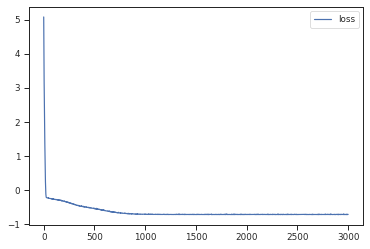

In [22]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Testing

In [23]:
x_test = np.ones((1, 1), dtype='float32')

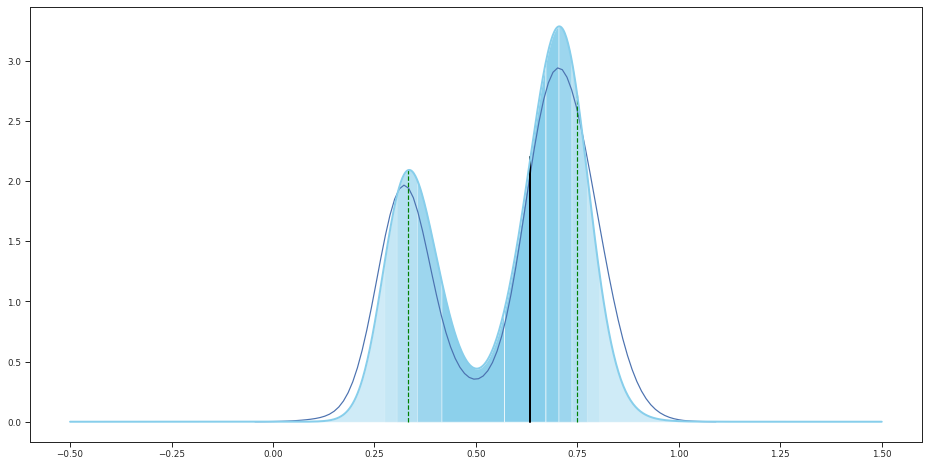

In [24]:
flow = flow_model(x_test)
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

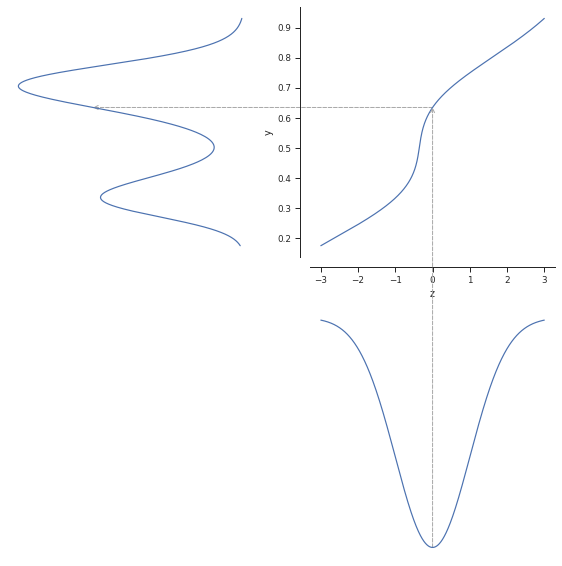

In [25]:
fig=vizualize_flow_from_z_domain(flow)

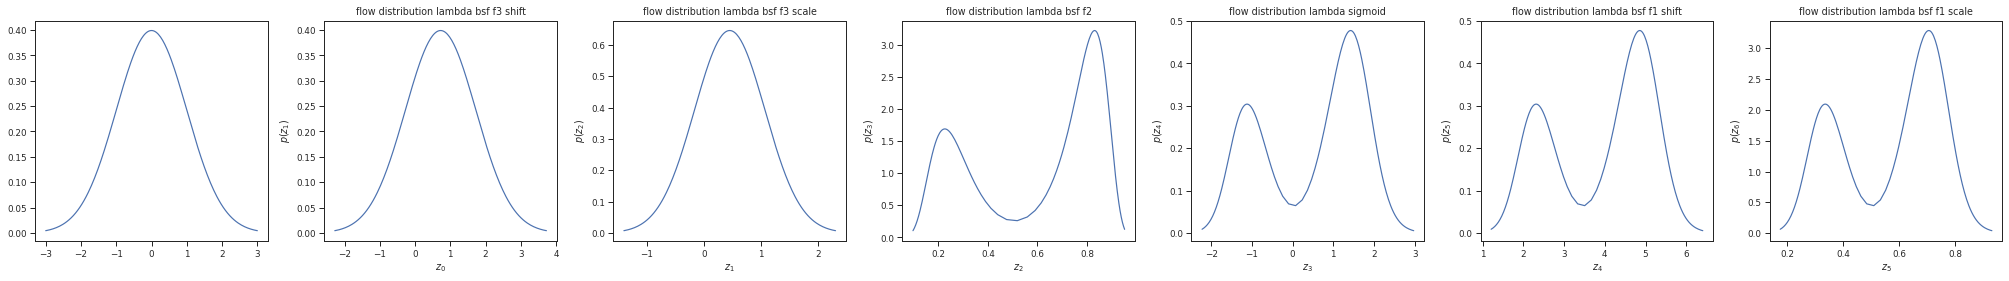

In [26]:
plot_chained_bijectors(flow)

In [27]:
b2 = flow.bijector.bijector.bijectors[0].shift
a2 = flow.bijector.bijector.bijectors[1].scale
theta = flow.bijector.bijector.bijectors[2].theta
b1 = flow.bijector.bijector.bijectors[4].shift
a1 = flow.bijector.bijector.bijectors[5].scale

In [28]:
print(f"""
a1 = {repr(a1.numpy())}
b1 = {repr(b1.numpy())}
theta = {repr(theta.numpy())}
a2 = {repr(a2.numpy())}
b2 = {repr(b2.numpy())}
""")


a1 = 6.8844566
b1 = -3.4302363
theta = array([[-3.484761  ,  0.22755575,  0.22755784,  0.22755788,  0.2275579 ,
         0.22755791,  0.22755794,  0.22755842,  3.3108506 ]],
      dtype=float32)
a2 = 1.6199291
b2 = -0.72408015



## Berstein Bijector as Loss

The Bernstein bijector can also be used as a Keras loss function.

### Model Definition

In [29]:
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin polynomial


OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

pvector = OutputLayer(
    4+M,
    name="pvector"
)(inputs)

out = Reshape((1, -1))(pvector)

flow_parameter_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[out],
    name='bs_loss')
flow_parameter_model.summary()

Model: "bs_loss"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pvector (Dense)              (None, 13)                13        
_________________________________________________________________
reshape (Reshape)            (None, 1, 13)             0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [30]:
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=BersteinFlowLoss(M)
)

### Training

In [31]:
# Do inference.
hist = flow_parameter_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<AxesSubplot:>, -0.7208577990531921)

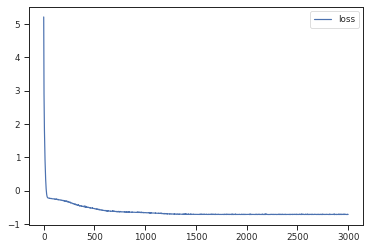

In [32]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Testing

In [33]:
x_test = np.ones((1, 1), dtype='float32')

In [34]:
pvs = flow_parameter_model(x_test)
flow = BersteinFlow(M)(pvs).distributions.model[0]

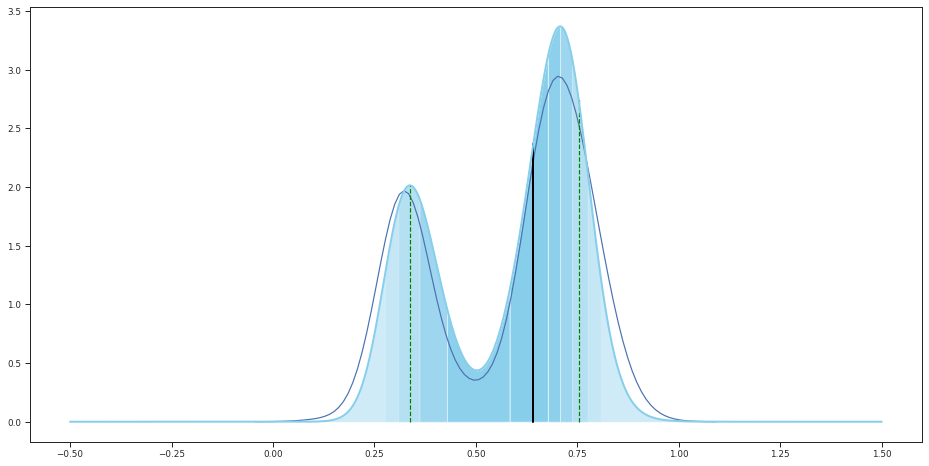

In [35]:
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

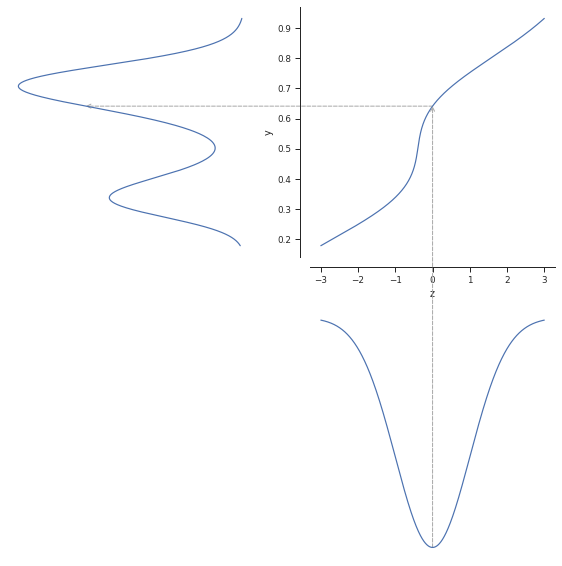

In [36]:
fig=vizualize_flow_from_z_domain(flow)

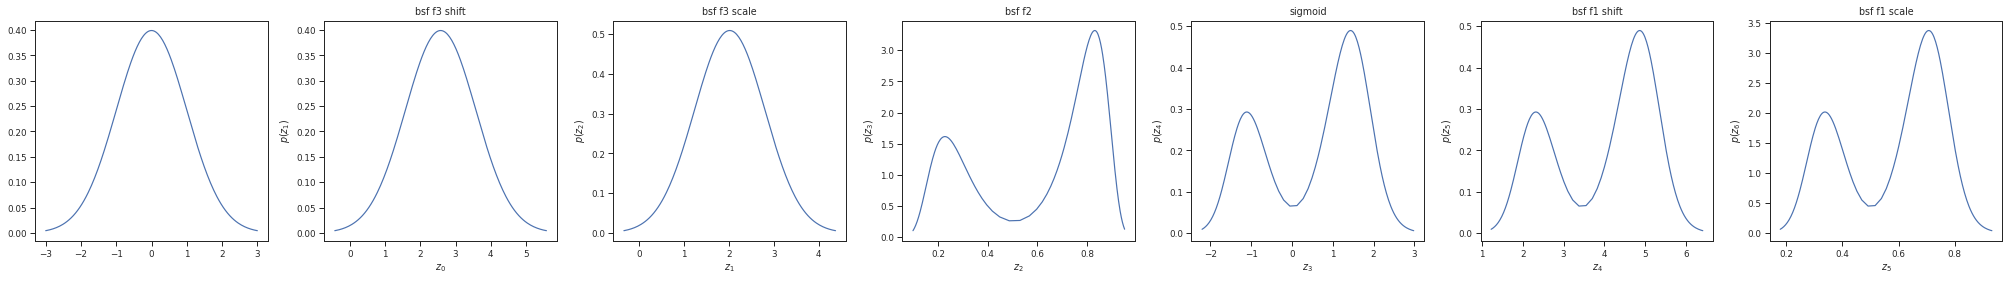

In [37]:
plot_chained_bijectors(flow)

# References

[<a id="cit-tabak-FamilyNonparametricDensity-2013" href="#call-tabak-FamilyNonparametricDensity-2013">1</a>] Tabak E. G. and Turner Cristina V., ``_A Family of Nonparametric Density Estimation Algorithms_'', , vol. 66, number 2, pp. 145--164,  2013.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpa.21423)

[<a id="cit-papamakarios-NormalizingFlowsProbabilistic-2019" href="#call-papamakarios-NormalizingFlowsProbabilistic-2019">2</a>] Papamakarios George, Nalisnick Eric, Rezende Danilo Jimenez <em>et al.</em>, ``_Normalizing Flows for Probabilistic Modeling and Inference_'', , vol. , number , pp. ,  2019.  [online](http://arxiv.org/abs/1912.02762)

[<a id="cit-hothorn-MostLikelyTransformations-2018" href="#call-hothorn-MostLikelyTransformations-2018">3</a>] Hothorn Torsten, Möst Lisa and Bühlmann Peter, ``_Most Likely Transformations_'', , vol. 45, number 1, pp. 110--134,  2018.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1111/sjos.12291)

[<a id="cit-sick-DeepTransformationModels-2020" href="#call-sick-DeepTransformationModels-2020">4</a>] Sick Beate, Hothorn Torsten and Dürr Oliver, ``_Deep transformation models: Tackling complex regression problems with neural network based transformation models_'', , vol. , number , pp. ,  2020.  [online](http://arxiv.org/abs/2004.00464)

[<a id="cit-azzalini-LookDataOld-1990" href="#call-azzalini-LookDataOld-1990">5</a>] Azzalini A. and Bowman A. W., ``_A Look at Some Data on the Old Faithful Geyser_'', , vol. 39, number 3, pp. 357--365,  1990.

